# CS 168 Spring Assignment 7

SUNet ID(s): 05794739

Name(s): Luis A. Perez

Collaborators: None

By turning in this assignment, I agree by the Stanford honor code and declare
that all of this is my own work.


# Imports

In [6]:
import collections
import matplotlib.pyplot as plt
import scipy

import numpy as np
from PIL import Image
from sklearn import decomposition
import pandas as pd
import seaborn as sns
import os
import warnings

import IPython

from typing import Dict, List, Text, Tuple

# Make figure larger
plt.rcParams['figure.figsize'] = [10, 5]

# Set numpy seed for consistent results.
np.random.seed(1)

In [7]:
class Globals:
    DATA_PATH = 'data/'

# Part 1

## Part 1b

In [8]:
def circle_graph(n=10):
    """Returns transition matrix for a circle graph."""
    A = np.zeros((n, n))
    for i in range(n):
        A[i, (i + 1) % n] = 1
        A[(i + 1) % n, i] = 1
    return 0.5 * A, 1 / n * np.ones((1, n))

def circle_graph_with_extra_edge(n=10, a=1, b=5):
    """Same as above but for a circle graph with an additional edge (a,b)."""
    P, _ = circle_graph(n=n)
    P[a-1, b-1] = 0.5
    P[b-1, a-1] = 0.5
    P[a-1, :] = P[a-1, :] * 2 / 3
    P[b-1, :] = P[b-1, :] * 2 / 3
    denom = 2*(n-2) + 3*2
    pi = 2 * np.ones((1, n)) / denom
    pi[0, a - 1] = 3 / denom
    pi[0, b - 1] = 3 / denom
    
    return P, pi

In [9]:
def variation_distance(x, y):
    return 1 / 2 * np.sum(np.abs(x - y))

def chain_mixing(T, pi):
    s = np.zeros((1, np.shape(T)[0]))
    s[0, 0] = 1
    distance = [variation_distance(s, pi)]
    for t in range(1, 101):
        s = np.dot(s, T)
        distance.append(variation_distance(s, pi))
        
    return distance

In [10]:
def problem1b():
    graphs = {
        '10-circle' : circle_graph(n=10),
        '9-circle': circle_graph(n=9),
        '9-circle-with-extra-edge': circle_graph_with_extra_edge(n=9)
    }
    for name, (T, pi) in graphs.items():
        dists = chain_mixing(T, pi)
        plt.plot(range(len(dists)), dists, label=name)
    plt.legend()
    plt.title('Distribution Mixing From Initial State on Node 1')
    plt.ylabel('Variational Distance')
    plt.xlabel('Mixing Time')
    plt.savefig('figures/mixing_time.png', format='png')
    plt.close()

In [11]:
problem1b()

## Part 1c

In [12]:
def problem1c():
    graphs = {
        '10-circle' : circle_graph(n=10),
        '9-circle': circle_graph(n=9),
        '9-circle-with-extra-edge': circle_graph_with_extra_edge(n=9)
    }
    for name, (T, _) in graphs.items():
        w, _ = np.linalg.eig(T.T)
        second_max_idx = len(w) - 2
        lambda2 = np.partition(w, second_max_idx)[second_max_idx]
        print(f'{name}')
        IPython.display.display(IPython.display.Math(f'\lambda_2={lambda2}'))

In [13]:
problem1c()

10-circle


<IPython.core.display.Math object>

9-circle


<IPython.core.display.Math object>

9-circle-with-extra-edge


<IPython.core.display.Math object>

# Part 2

In [14]:
def route_length(D, idx):
    """Computes total length of route visiting the specified idx in order."""
    return sum([D[idx[i], idx[i+1]] for i in range(len(idx) - 1)])

def load_distance():
    """Loads a matrix containing all pair-wise distances between all parks."""
    data = pd.read_csv(os.path.join(Globals.DATA_PATH, 'parks.csv'))
    X = np.stack((data['Longitude'], data['Latitude'])).T
    n = np.shape(X)[0]
    X2 = np.diag(np.dot(X, X.T)).reshape((n, 1))
    Y2 = X2.reshape((1, n))
    XY = np.dot(X, X.T)
    D = np.sqrt(X2 + Y2 - 2*XY)
    park_to_idx = {name: i for i, name in enumerate(data['Name'])}
    idx_to_park = {i : name for name, i in park_to_idx.items()}
    
    # Sanity checks.
    assert np.allclose(D[park_to_idx['Acadia'], park_to_idx['Arches']], 41.75, rtol=1e-4)
    assert np.allclose(route_length(D, list(range(n)) + [0]), 491.92)
    return D, park_to_idx, idx_to_park

## Part 2a

In [15]:
def mcmc(D, n_iters, T, route_fn):
    """Implements MCMC for Eucledian Traveling Salesmen on Distance Matrix D."""
    route = np.array(range(D.shape[0]))
    np.random.shuffle(route)
    best = route.copy()
    
    selected = np.random.choice(range(D.shape[0]), replace=True, size=n_iters)
    selected2 = np.random.choice(range(D.shape[0]), replace=True, size=n_iters)
    route_dists = []
    for idx, idx2 in zip(selected, selected2):
        newroute = route.copy()
        route_fn(route, newroute, idx, idx2)
        route_dist = route_length(D, route.tolist() + [route[0]])
        newroute_dist = route_length(D, newroute.tolist() + [newroute[0]])
        route_dists.append(route_dist)
        delta_dist = newroute_dist - route_dist
        if delta_dist < 0 or (T > 0 and np.random.uniform() < np.exp(-delta_dist / T)):
            route = newroute
        if route_length(D, route.tolist() + [route[0]]) < route_length(D, best.tolist() + [best[0]]):
            best = route
    return best, route_dists

## Part 2b

In [18]:
def sequential_modify(route, newroute, idx, idx2):
    del idx2
    next_idx = (idx + 1) % route.shape[0]
    newroute[idx] = route[next_idx]
    newroute[next_idx] = route[idx]
    
def problem2b():
    D, park_to_idx, idx_to_park = load_distance()
    for T in [0, 1, 10, 100]:
        best_length = None
        for trial in range(10):
            _, y = mcmc(D, n_iters=10000, T=T, route_fn=sequential_modify)
            plt.plot(range(len(y)), y, label=f'trial_idx={trial + 1}')
            if best_length is None or min(y) < best_length:
                best_length = min(y)

        plt.legend()
        plt.title(f'Current Route by Iteration for T={T}')
        plt.xlabel('Iteration')
        plt.ylabel('Route Distance')
        plt.savefig(f'figures/route_by_iteration_t={T}.png', format='png')
        plt.close()
        
        print(f'[T={T}]The best found route over all trials was: {best_length:.2f}.')

In [19]:
problem2b()

[T=0]The best found route over all trials was: 381.04.
[T=1]The best found route over all trials was: 339.59.
[T=10]The best found route over all trials was: 252.43.
[T=100]The best found route over all trials was: 349.54.


## Problem 2c

In [20]:
def random_modify(route, newroute, idx, idx2):
    newroute[idx] = route[idx2]
    newroute[idx2] = route[idx]
    
def problem2c():
    D, park_to_idx, idx_to_park = load_distance()
    for T in [0, 1, 10, 100]:
        best_length = None
        for trial in range(10):
            _, y = mcmc(D, n_iters=10000, T=T, route_fn=random_modify)
            if best_length is None or min(y) < best_length:
                best_length = min(y)
            plt.plot(range(len(y)), y, label=f'trial_idx={trial + 1}')
        plt.legend()
        plt.title(f'Current Route by Iteration for T={T}')
        plt.xlabel('Iteration')
        plt.ylabel('Route Distance')
        plt.savefig(f'figures/route_by_iteration_t={T}_random.png', format='png')
        plt.close()
        
        print(f'[T={T}]The best found route over all trials was: {best_length:.2f}.')

In [21]:
problem2c()

[T=0]The best found route over all trials was: 178.69.
[T=1]The best found route over all trials was: 167.12.
[T=10]The best found route over all trials was: 247.77.
[T=100]The best found route over all trials was: 303.14.


# Part 3

# Part 3a

In [22]:
import importlib
import qwop
importlib.reload(qwop)
from matplotlib import animation

In [23]:
def draw_simulation(data, path):
    fig = plt.figure()
    fig.set_dpi(100)
    fig.set_size_inches(12, 3)
    
    ax = plt.axes(xlim=(-1, 10), ylim=(0, 3))
    
    joints = [5, 0, 1, 2, 1, 0, 3, 4]
    patch = plt.Polygon([[0, 0], [0, 0]], closed=None, fill=None, edgecolor='k')
    head = plt.Circle((0, 0), radius=0.15, fc='k', ec='k')
    
    def init():
        ax.add_patch(patch)
        ax.add_patch(head)
        return patch, head
    
    def animate(j):
        points = zip([data[j][0][i] for i in joints],
                     [data[j][1][i] for i in joints])
        patch.set_xy(list(points))
        head.center = (data[j][0][5], data[j][1][5])
        return patch, head
    
    anim = animation.FuncAnimation(fig,
                               animate,
                               init_func=init,
                               frames=len(data),
                               interval=20)


    anim.save(f'{path}.mp4', fps=50)
    plt.close()

In [50]:
def mcmc_sim(n_iters, route=None):
    """Implements MCMC QWOP Simulation"""
    step_size = 0.01
    if route is None:
        route = np.random.choice(np.arange(-1, 1, step_size), size=40)
    route_value = qwop.sim(route, include_data=False)[0]
    best = route.copy()
    best_value = route_value
    route_dists = [route_value]
    for i in range(n_iters):
        newroute = np.clip(route + np.random.choice(np.arange(-0.25, 0.25, step_size), size=40), -1, 1)
        newroute_value = qwop.sim(newroute, include_data=False)[0]
        if newroute_value > route_value:
            route = newroute
            route_value = newroute_value
        if route_value > best_value:
            best = route
            best_value = route_value
            print(f'New best: {best_value:.2f} at iteration {i + 1}.')
    return best, best_value, route_dists

In [51]:
best_plan, best_value, _ = mcmc_sim(1000000, best_plan)

In [53]:
best_value

9.198867470630958

In [54]:
best_plan

array([ 0.36,  0.49,  0.88,  0.85,  1.  ,  1.  ,  0.74,  1.  , -1.  ,
       -0.83,  0.29,  0.16,  0.8 ,  0.73,  0.57, -0.61,  0.77,  0.95,
       -0.96, -0.08, -0.3 , -1.  , -0.82, -1.  ,  0.95,  0.48, -1.  ,
        0.72, -0.78, -1.  , -0.11, -0.9 ,  0.78, -0.26,  0.57,  0.15,
        0.09, -0.88, -0.86, -0.5 ])

In [52]:
_, data = qwop.sim(best_plan)
draw_simulation(data, 'figures/best_mcmc_5')

In [33]:
best_plan = None
best_value = 0
for _ in range(10):
    small_plan, small_value, _ = mcmc_sim(n_iters=20000)
    if best_plan is None or best_value < small_value:
        best_plan = small_plan
        best_value = small_value

New best: -0.95 at iteration 2.
New best: -0.18 at iteration 3.
New best: 0.20 at iteration 4.
New best: 0.23 at iteration 6.
New best: 3.11 at iteration 7.
New best: 3.16 at iteration 13.
New best: 3.75 at iteration 24.
New best: 3.79 at iteration 184.
New best: 4.02 at iteration 270.
New best: 4.33 at iteration 439.
New best: 4.36 at iteration 581.
New best: 4.76 at iteration 647.
New best: 4.80 at iteration 680.
New best: 4.88 at iteration 759.
New best: 5.11 at iteration 1053.
New best: 5.19 at iteration 1117.
New best: 5.32 at iteration 1184.
New best: 5.47 at iteration 1241.
New best: 5.67 at iteration 1296.
New best: 5.72 at iteration 1372.
New best: 6.26 at iteration 1389.
New best: 6.49 at iteration 2911.
New best: 6.61 at iteration 3080.
New best: 6.69 at iteration 4231.
New best: 6.90 at iteration 4560.
New best: 6.99 at iteration 4687.
New best: 7.13 at iteration 5244.
New best: 7.15 at iteration 7356.
New best: 7.21 at iteration 13426.
New best: 1.65 at iteration 2.
New be

New best: 1.33 at iteration 3.
New best: 1.36 at iteration 4.
New best: 1.57 at iteration 5.
New best: 1.72 at iteration 6.
New best: 4.37 at iteration 9.
New best: 4.38 at iteration 87.
New best: 4.75 at iteration 167.
New best: 5.52 at iteration 405.
New best: 6.16 at iteration 664.
New best: 6.22 at iteration 5028.
New best: 6.29 at iteration 5428.
New best: 6.37 at iteration 5611.
New best: 6.52 at iteration 6203.
New best: 6.68 at iteration 6233.
New best: 7.05 at iteration 6274.
New best: 7.45 at iteration 6292.
New best: 7.68 at iteration 6316.
New best: 7.74 at iteration 8332.
New best: 8.06 at iteration 10709.
New best: 8.13 at iteration 14099.
New best: 8.26 at iteration 14676.
New best: 8.35 at iteration 18393.


In [36]:
_, data = qwop.sim(best_plan)
draw_simulation(data, 'figures/best_mcmc_2')

In [342]:
plan, value, _ = mcmc_sim(n_iters=10000, T=0)

New best: 1.62 at iteration 2.
New best: 1.69 at iteration 4.
New best: 1.74 at iteration 5.
New best: 1.90 at iteration 6.
New best: 2.19 at iteration 7.
New best: 2.56 at iteration 12.
New best: 2.65 at iteration 27.
New best: 2.68 at iteration 87.
New best: 2.76 at iteration 88.
New best: 3.11 at iteration 89.
New best: 3.12 at iteration 99.
New best: 3.65 at iteration 117.
New best: 3.84 at iteration 119.
New best: 4.02 at iteration 159.
New best: 4.05 at iteration 169.
New best: 4.27 at iteration 247.
New best: 4.33 at iteration 331.
New best: 4.35 at iteration 433.
New best: 4.51 at iteration 437.
New best: 4.83 at iteration 451.
New best: 4.91 at iteration 541.
New best: 5.04 at iteration 661.
New best: 5.06 at iteration 689.
New best: 5.08 at iteration 1124.
New best: 5.13 at iteration 1337.
New best: 5.22 at iteration 1393.
New best: 5.32 at iteration 1568.
New best: 5.54 at iteration 1595.
New best: 5.77 at iteration 1759.
New best: 5.87 at iteration 1906.
New best: 6.00 at i

In [357]:
plan

array([ 3.32046582e-01,  8.64347977e-01, -5.36958882e-01,  1.33757192e-01,
       -7.46647497e-02,  5.20644096e-02,  1.38249558e-01,  4.68027199e-01,
        2.38875307e-01,  5.97549589e-01, -1.31011744e-01,  3.00758848e-01,
       -8.75100380e-01, -1.00000000e+00,  5.33726082e-01,  7.10140454e-01,
        8.44800416e-01,  1.00000000e+00, -6.50942301e-01, -8.15635219e-01,
       -6.90576364e-01,  4.99978093e-01, -9.96742325e-01, -6.18842000e-01,
        2.73972411e-01, -5.08626797e-01, -5.25919503e-01, -3.93425059e-01,
       -8.71606742e-01, -3.69966358e-01,  8.81972954e-02, -2.36058686e-01,
       -9.45380799e-01, -4.99008952e-01,  4.76229721e-01, -6.72647790e-04,
        7.42384034e-01, -5.09676613e-01, -8.47599711e-01,  8.12253360e-01])

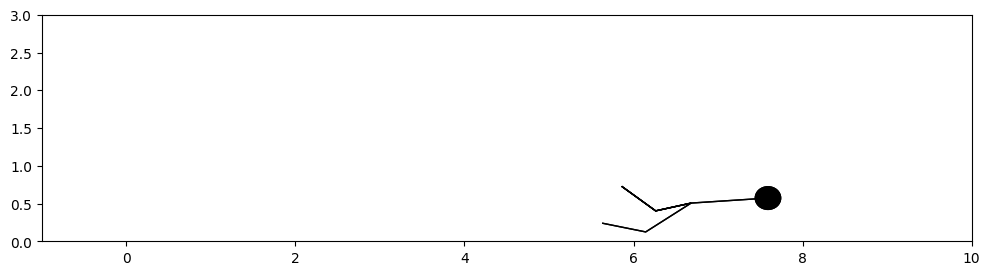

In [356]:
_, data = qwop.sim(plan)
draw_simulation(data, 'figures/best_mcmc')

In [298]:
best, routes[]

(array([-0.78027422,  0.0309237 ,  0.01693435, -0.655999  , -0.95880106,
        -0.96315125, -0.76193845, -0.86024011,  0.75840799,  0.66953856,
         0.85208282, -0.47579035,  0.82885493,  0.73460846, -0.15858533,
         0.98560189,  0.42121195,  0.57024489, -0.79955204, -0.128188  ,
        -0.86051161, -0.77008358,  0.43200857, -0.4883419 ,  0.48698762,
         0.12144517,  0.56585249, -0.29193376,  0.53723171,  0.58063392,
         0.51053619,  0.60100035, -0.80468913, -0.43719093,  0.64147052,
         0.56480972, -0.64413858,  0.44152763, -0.33662148,  0.27307277]),
 [-0.371670043066106,
  -0.371670043066106,
  -0.371670043066106,
  -0.371670043066106,
  -0.371670043066106,
  -0.27609286547633904,
  -0.27609286547633904,
  -0.1123038006366276,
  -0.1123038006366276,
  -0.1123038006366276,
  -0.1123038006366276,
  -0.09960110423113729,
  -0.09960110423113729,
  -0.09960110423113729,
  -0.09960110423113729,
  -0.09960110423113729,
  -0.09960110423113729,
  -0.099601104231137

In [25]:
import torch